<a href="https://colab.research.google.com/github/D59AI/CrowdMonitoring/blob/main/CrowdMonitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


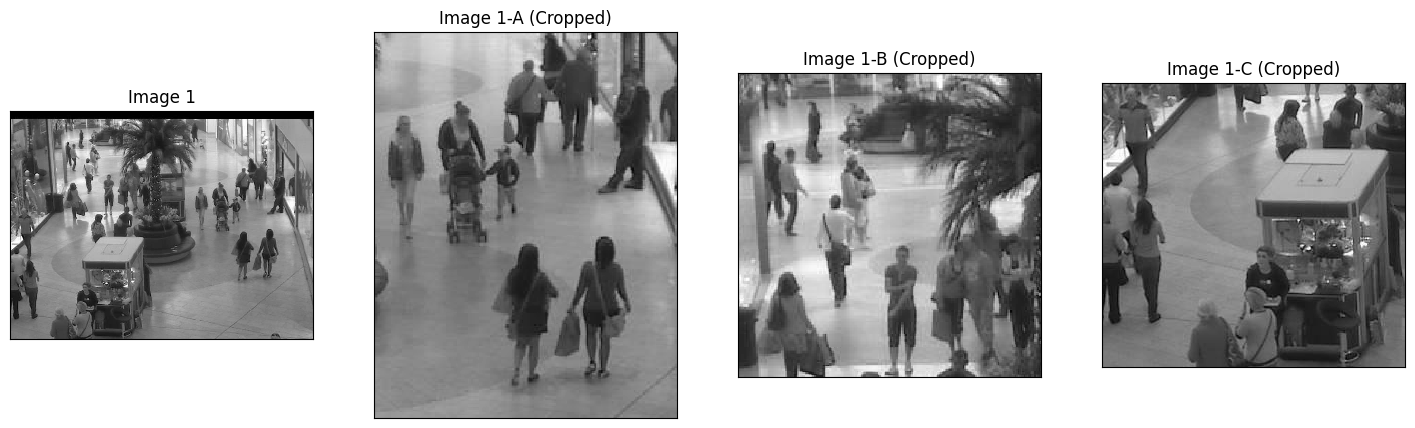

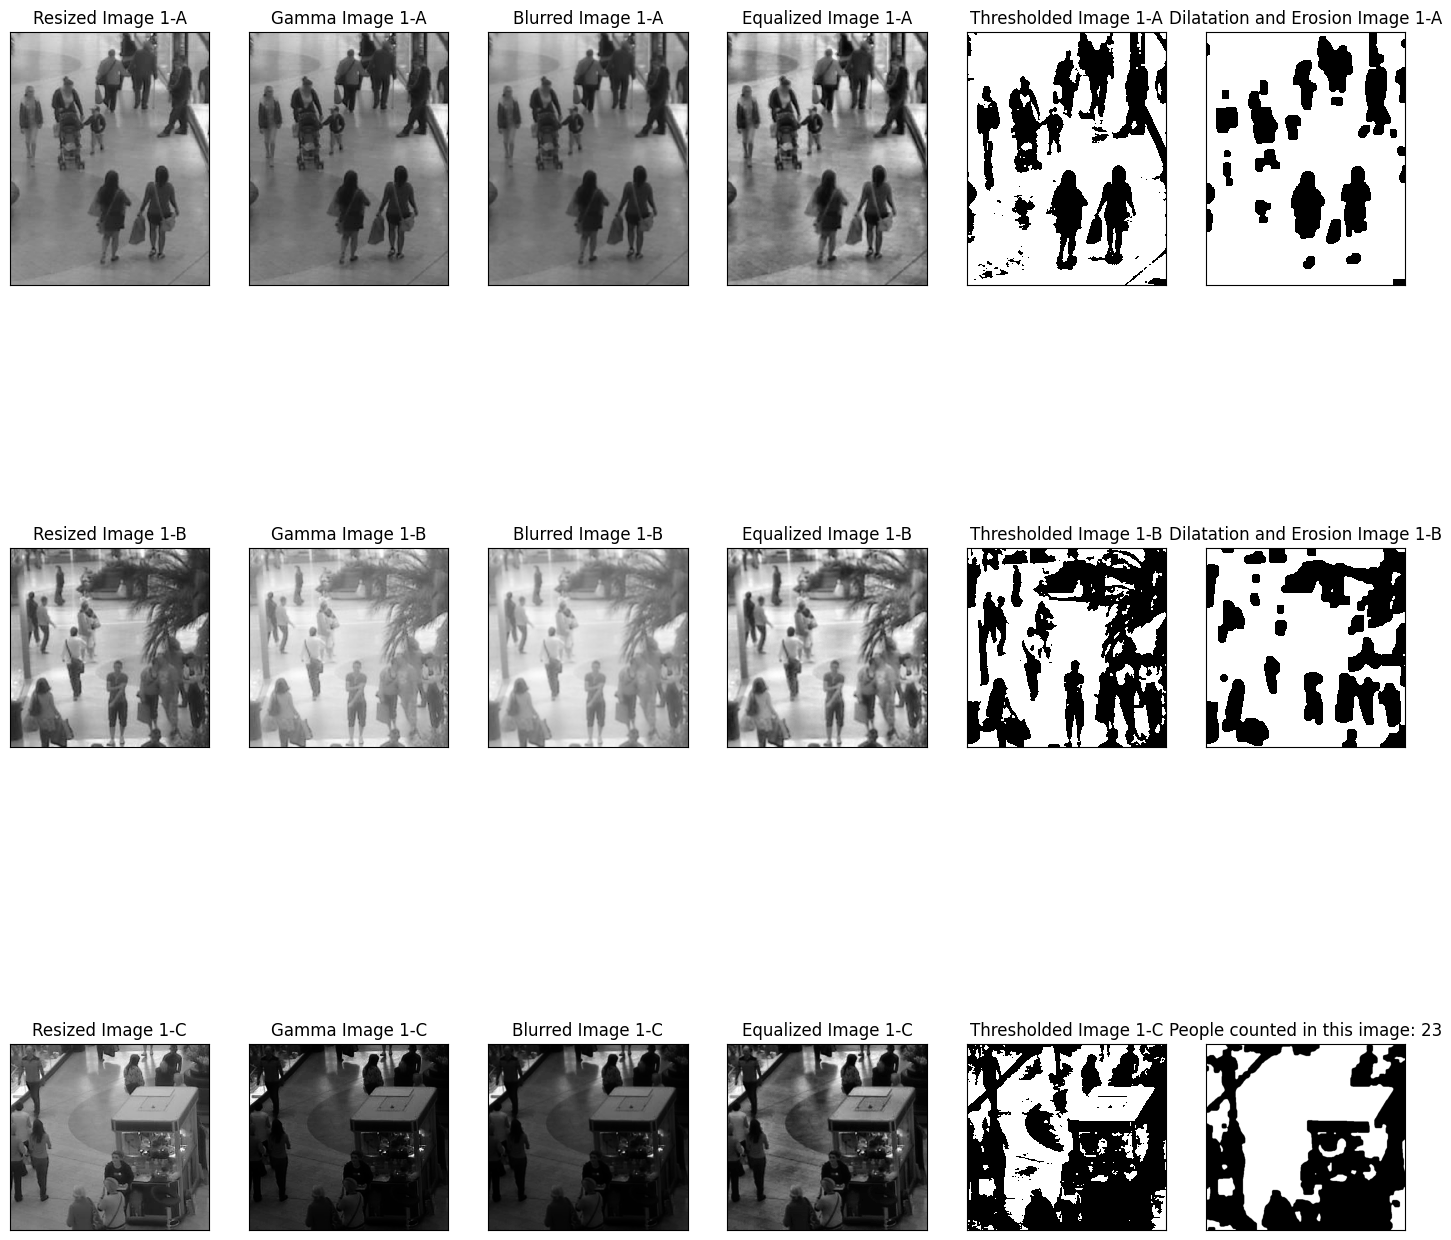

People counted in Image 1: 23


In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Function to display images in a grid layout
def plotting_grid(images, titles, rows, cols, figsize):
    fig, axes = plt.subplots(rows, cols, figsize=(figsize, figsize))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray', vmin=0, vmax=255, interpolation='none')
        ax.set_title(titles[i])
        ax.set_xticks([]), ax.set_yticks([])
# Function to perform cropping
def crop(image, start_y, end_y, start_x, end_x):
    try:
        img_cropped = image[start_y:end_y, start_x:end_x]
        return img_cropped
    except Exception as e:
        print(f"Error during cropping: {e}")
        return None
# Function to perform resizing
def resize(image, width, height):
    try:
        img_resized = cv2.resize(image, (width, height))
        return img_resized
    except Exception as e:
        print(f"Error during resizing: {e}")
        return None
# Function for gamma correction
def gamma_correction(image, y):
    try:
        gamma_correct = np.array(255 * (image / 255) ** y, dtype='uint8')
        return gamma_correct
    except Exception as e:
        print(f"Error during gamma correction: {e}")
        return None
# Function for adaptive histogram equalization
def adaptive_histogram_equalization(image):
    try:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_equalized = clahe.apply(image)
        return img_equalized
    except Exception as e:
        print(f"Error during adaptive histogram equalization: {e}")
        return None
# Function for Otsu's thresholding
def otsu_threshold(image):
    try:
        _, img_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return img_thresh
    except Exception as e:
        print(f"Error during Otsu's thresholding: {e}")
        return None
# Function for dilation and erosion
def dilation_erosion(image):
    try:
        kernel = np.ones((15, 15), np.uint8)
        img_dilation = cv2.dilate(image, kernel, iterations=1)
        img_erode = cv2.erode(img_dilation, kernel, iterations=1)
        img_erode = cv2.medianBlur(img_erode, 7)
        return img_erode
    except Exception as e:
        print(f"Error during dilation and erosion: {e}")
        return None
# Function for labeling using contours
def labeling(image):
    try:
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        labeled_img = cv2.drawContours(np.zeros_like(image), contours, -1, (255), thickness=cv2.FILLED)
        count = len(contours)
        plt.title('People counted in this image: ' + str(count))
        plt.imshow(labeled_img, cmap='gray')
        plt.show()
        return count
    except Exception as e:
        print(f"Error during labeling: {e}")
        return None
# Load images
image_paths = [
    '/seq_000002.jpg',

]
# Process images
total_people_count = 0
for i, img_path in enumerate(image_paths):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Check if image is successfully loaded
        if img is None:
            print(f"Error: Unable to load image at path: {img_path}")
            continue
        # Crop, Resize, Gamma Correction
        cropped_images, cropped_titles = [], []
        for j, (start_y, end_y, start_x, end_x) in enumerate([(100, 380, 380, 600), (20, 220, 100, 300), (200, 500, 0, 300)]):
            # Crop
            cropped_img = crop(img, start_y, end_y, start_x, end_x)
            if cropped_img is not None:
                cropped_images.append(cropped_img)
                cropped_titles.append(f'Image {i + 1}-{chr(ord("A") + j)} (Cropped)')
        # Display original image and cropped images in a grid
        all_images = [img] + cropped_images
        all_titles = [f'Image {i + 1}'] + cropped_titles
        plotting_grid(all_images, all_titles, 1, len(all_images), 18)
        # Resize, Gamma Correction, Adaptive Histogram Equalization, Otsu's Thresholding, Dilation and Erosion
        processed_images, processed_titles = [], []
        for j, cropped_img in enumerate(cropped_images):
            # Resize
            multiplier = 2
            resized_img = resize(cropped_img, cropped_img.shape[1] * multiplier, cropped_img.shape[0] * multiplier)
            if resized_img is None:
                continue
            # Gamma correction
            gamma_value = [1.2, 0.5, 2.5][j]
            gamma_corrected_img = gamma_correction(resized_img, gamma_value)
            if gamma_corrected_img is None:
                continue
            # Apply Gaussian blur for smoothing
            blurred_img = cv2.GaussianBlur(gamma_corrected_img, (5, 5), 0)
            # Adaptive histogram equalization
            equalized_img = adaptive_histogram_equalization(blurred_img)
            if equalized_img is None:
                continue
            # Adaptive thresholding
            thresholded_img = otsu_threshold(equalized_img)
            if thresholded_img is None:
                continue
            # Dilation and Erosion
            dlt_er_img = dilation_erosion(thresholded_img)
            if dlt_er_img is None:
                continue
            processed_images.extend([resized_img, gamma_corrected_img, blurred_img, equalized_img, thresholded_img, dlt_er_img])
            processed_titles.extend([
                f'Resized Image {i + 1}-{chr(ord("A") + j)}',
                f'Gamma Image {i + 1}-{chr(ord("A") + j)}',
                f'Blurred Image {i + 1}-{chr(ord("A") + j)}',
                f'Equalized Image {i + 1}-{chr(ord("A") + j)}',
                f'Thresholded Image {i + 1}-{chr(ord("A") + j)}',
                f'Dilatation and Erosion Image {i + 1}-{chr(ord("A") + j)}'
            ])
        # Display processed images in a grid
        plotting_grid(processed_images, processed_titles, len(cropped_images), 6, 18)
        # Labeling using contours
        count = labeling(dlt_er_img)
        if count is not None:
            total_people_count += count
        # Print the count for the current image
        print(f'People counted in Image {i + 1}: {count}')
    except Exception as e:
        print(f"Error processing image {i + 1}: {e}")